In [1]:
from processing_functions import *
from classifier_oop import *
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")


In [2]:
processed_data = pd.read_csv('./processed_dataset/recent_propagated_dataset.csv', index_col=0)
missing_df = pd.read_csv('./missing_features/combined_missing.csv', index_col=0)

In [3]:
screen_data_cols = ['study_yr', 'detl_p', 'detr_p', 'lvol_p', 'rvol_p', 'lvol_q', 'rvol_q',
       'lantero_p', 'lantero_q', 'llong_p', 'llong_q', 'ltran_p', 'ltran_q',
       'rantero_p', 'rantero_q', 'rlong_p', 'rlong_q', 'rtran_p', 'rtran_q',
       'tvu_ref', 'phycons', 'tvu_result', 'ca125_result', 'ovar_result',
       'ovcyst_solidr', 'ovcyst_outliner', 'ovcyst_solidl', 'ovcyst_outlinel',
       'ovcyst_solid', 'ovcyst_outline', 'ovcyst_diamr', 'ovcyst_diaml',
       'ovcyst_diam', 'ovcyst_volr', 'ovcyst_voll', 'ovcyst_vol',
       'ovcyst_morphr', 'ovcyst_morphl', 'ovcyst_morph', 'ovcyst_sumr',
       'ovcyst_suml', 'ovcyst_sum', 'ovary_diam', 'ovary_diamr', 'ovary_diaml',
       'ovary_volr', 'ovary_voll', 'ovary_vol', 'visl', 'visr', 'visboth',
       'viseith', 'numcystl', 'numcystr', 'numcyst', 'plco_id', 'ovar_days']

screen_abnorm_data_cols = ['study_yr', 'solid', 'sepst', 'cyst', 'cystw', 'echo', 'maxdi', 'volum',
       'plco_id']

screened_cols = screen_data_cols + screen_abnorm_data_cols + ['ca125ii', 'ca125_result']

## Merging Datasets

I realized that I was doing labeled mean imputation, which should not happen. So, I performed imputation after I merged cancer and no_cancer datasets back together. Without labeled mean imputation, gaussian NB and logistic regression do not perform well. 

run experiments with decision tree and remove the top feature every time. Store the depth of the tree, the efficacy of the top feature, its value, accuracy, confusion matrix

https://stackoverflow.com/questions/62819569/how-to-return-the-features-that-used-in-decision-tree-that-created-by-decisiontr

`TODO:` Run model purely on family history variables vs purely on screen variables. 

In [4]:

def feature_selection(classifier, fn, accuracy, plot_tree=False, filepath='./trees/decision_tree.png'):
    
    if plot_tree:
        cn=['no cancer', 'cancer']
        if classifier.__class__.__name__ == 'DecisionTreeClassifier':
            fig, axes = plt.subplots(nrows = 1,ncols = 1, dpi=3000)
            tree.plot_tree(classifier,
                        max_depth=5,
                feature_names = fn, 
                class_names=cn,
                filled = True)
            plt.savefig(filepath)
            # plt.show()
        if classifier.__class__.__name__ == 'XGBClassifier':
            # fig, axes = plt.subplots(nrows = 1,ncols = 1, dpi=3000)
            fig, axes = plt.subplots(nrows = 1,ncols = 1, dpi=6000)
            # plt.gcf().set_size_inches(18.5, 10.5)
            xgb.plot_tree(classifier, rankdir='LR', ax=axes)
            plt.savefig(filepath)
    feature_importances = pd.DataFrame(classifier.feature_importances_,
                        index = fn,
                        columns=['importance']).sort_values('importance', 
                                                            ascending=False)
    feature_importances['column_name'] = feature_importances.index
    feature_importances = feature_importances[['column_name', 'importance']]
    # TODO: boundary and confusion matrix
    tree_depth = None
    if classifier.__class__.__name__ == 'DecisionTreeClassifier':
        tree_depth = classifier.tree_.max_depth
    if classifier.__class__.__name__ == 'XGBClassifier':
        tree_depth = classifier.max_depth
    top_feature_stats = {
        'top_feature': feature_importances.iloc[0]['column_name'],
        # 'boundary': 0,
        'num_features_used': len(feature_importances[feature_importances['importance'] > 0]),
        'importance': round(feature_importances.iloc[0]['importance'], 3),
        'tree_depth': tree_depth,
        'accuracy': accuracy,
        # 'precision': precision,
        # 'recall':    recall,
        # 'f1-score':  f1,
    }
    return top_feature_stats, feature_importances



In [5]:
def get_cv_scores(classifier, k_fold_lambdas):
    cv_scores = []
    # pipeline = make_pipeline(StandardScaler(), classifier)
    df_feature_importance_tree = None
    for k, k_fold_lambda in enumerate(k_fold_lambdas):
        X_train, X_test, y_train, y_test = k_fold_lambda()
        # pipeline.fit(X_train_cv, y_train_cv)
        # score = pipeline.score(X_test_cv, y_test_cv)
        trained_classifier, auc, accuracy, threshold, report = run_classifier(classifier, X_train, X_test, y_train, y_test, show_graph=False)
        cv_scores.append(report)
        # print(f'Fold: {k+1}, Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, Auc: {auc:.3f}')
        # Decision Tree feature selection
        if classifier.__class__.__name__ in ['DecisionTreeClassifier', 'XGBClassifier']:
            fn=X_train.columns
            top_feature_stats, feature_importances = feature_selection(classifier, fn, accuracy, plot_tree=False)
            feature_importances = feature_importances[feature_importances['importance'] > 0]
            if df_feature_importance_tree is not None:
                df_feature_importance_tree = df_feature_importance_tree.merge(feature_importances, on='column_name', how='outer', suffixes=[f'_tiral_{k}', f'_tiral_{k+1}'])
            else:
                df_feature_importance_tree = feature_importances
    cv_scores = pd.concat(cv_scores)
    cv_scores = cv_scores.reset_index()
    cv_scores = cv_scores.drop('index', axis=1)
    measures_df = cv_scores.describe().T[['mean', 'std', 'min', 'max']]
    print('\n\nCross-Validation measures:')
    print_df(measures_df)
    if classifier.__class__.__name__ in ['DecisionTreeClassifier', 'XGBClassifier']:
        # Mean of feature importance over trials
        df_feature_importance_mean = df_feature_importance_tree.drop('column_name', axis=1)
        df_feature_importance_mean = df_feature_importance_mean.T
        df_feature_importance_mean.columns = df_feature_importance_tree['column_name']
        df_feature_importance_mean = df_feature_importance_mean.astype('float')
        df_feature_importance_mean_describe = df_feature_importance_mean.describe().T
        df_feature_importance_mean_describe.sort_values('mean', ascending=False, inplace=True)
        # print(df_feature_importance_mean_describe.columns)
        df_feature_importance_mean_describe = df_feature_importance_mean_describe[['count', 'mean']]
        # print_df(df_feature_importance_mean_describe)
    df_feature_importance_mean_describe = df_feature_importance_mean_describe.merge(missing_df, on='column_name')
    return cv_scores, measures_df, df_feature_importance_mean_describe


`TODO:` https://machinelearningmastery.com/visualize-gradient-boosting-decision-trees-xgboost-python/

In [6]:
def scale_features(df):
    sc = StandardScaler()
    df_scaled = df.copy()
    df_scaled = sc.fit_transform(df_scaled)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)
    return df_scaled

In [7]:
def get_nearest_neighbors(df1, df2, top=5):
    df1 = df1.drop_duplicates()
    df2 = df2.drop_duplicates()
    df1 = scale_features(df1)
    df2 = scale_features(df2)
    euclidean_distances = []
    indexes = []
    for i in range(len(df1)):
        row1 = df1.iloc[i]
        distances = []
        for j, row2 in df2.iterrows():
            distances.append((j, distance.euclidean(row1, row2)))
        distances = sorted(distances, key=lambda x: x[1], reverse=False)[:top]
        distances = pd.DataFrame(distances, columns=['index', 'distance'])
        indexes.append((distances['index'].to_list()))
        euclidean_distances.append(distances['distance'].to_list())
    return euclidean_distances, indexes

def get_high_confidence_errors(classifier, X_train, X_test, y_train, y_test, label, label_val=0):
    # Insert predicted class and its likelihood
    X_train = X_train.copy()
    X_test = X_test.copy()
    y_pred = classifier.predict(X_test)
    y_prob = classifier.predict_proba(X_test)[:,1]
    X_test_mismatch = X_test.copy()
    X_test_mismatch[label] = y_test
    X_test_mismatch[f'{label}_pred'] = y_pred
    X_test_mismatch[f'{label}_prob'] = y_prob
    X_test_mismatch = X_test_mismatch.drop_duplicates()
    X_test_mismatch = X_test_mismatch[X_test_mismatch[label] != X_test_mismatch[f'{label}_pred']]
    
    # X_test_high_conf = X_test_mismatch[(X_test_mismatch[f'{label}_prob'] < 0.2) | (X_test_mismatch[f'{label}_prob'] > 0.8)]
    X_test_high_conf = X_test_mismatch
    X_test_high_conf = X_test_high_conf[X_test_high_conf[f'{label}_pred'] == label_val]
    
    # Select 5 nearest neightbors 
    X_train[label] = y_train
    X_train_filtered = X_train[X_train[label] == label_val].drop(label, axis=1)
    # X_test_high_conf = X_test.loc[X_test_high_conf.index, :]
    # Calculated euclidean distances
    distances, indices = get_nearest_neighbors(X_test.loc[X_test_high_conf.index, :], X_train_filtered)
    fp_mismatches = []
    X_train[f'{label}_pred'] = -1
    X_train[f'{label}_prob'] = -1
    X_train = X_train.drop_duplicates()
    # print_df(X_train)
    for i in range(len(X_test_high_conf)):
        idx = indices[i]
        missed_record = X_test_high_conf.iloc[[i], :]
        missed_record['distance'] = 0
        close_records = X_train.loc[idx, :]
        close_records['distance'] = distances[i]
        fp_mismatches.append((missed_record, close_records))
    return fp_mismatches

In [8]:
def run_classifiers(classifiers, df, label, strategy='median', drop_n_features = 1, num_folds=10, cv=False, plot_tree=False, differentiate_confusion_matrix_over=None):
    df_feature_importance_tree = None
    df_top_feature_importances = []
    for i in range(drop_n_features):
        
        train_test_lambda, k_fold_lambdas = process_and_impute_for_label_kfold(df, label, strategy, n_max_per_class=10000, num_folds=num_folds, differentiate_confusion_matrix_over=differentiate_confusion_matrix_over)
        X_train, X_test, y_train, y_test, differentiated_test_sets = train_test_lambda()
        auc_dict = {}
        accuracy_dict = {}
        top_feature_importance = []
        for classifier_type, classifier in classifiers.items():
            # Cross Validation
            if cv:
                cv_scores, measures_df, df_feature_importance_mean_describe = get_cv_scores(classifier, k_fold_lambdas)
                cv_scores.to_csv(f'./cv_scores/cv_scores_for_{classifier_type}_{label}.csv')
                measures_df.to_csv(f'./cv_scores/cv_stats_for_{classifier_type}_{label}.csv')
                if classifier_type in ['DecisionTreeClassifier', 'XGBClassifier']:
                    df_feature_importance_mean_describe.to_csv(f'./feature_importance/feature_importance_mean_{classifier_type}_{label}__{num_folds}_trials.csv')

            # Test classifier
            print(classifier_type)
            trained_classifier, auc, accuracy, threshold, report = run_classifier(classifier, X_train, X_test, y_train, y_test)
            print(threshold)
            filtered_on = list(itertools.chain.from_iterable([zip([key]*len(vals), vals) for key, vals in differentiate_confusion_matrix_over.items()]))
            for i, (X_test_filtered, y_test_filtered) in enumerate(differentiated_test_sets):
                print(f'Filtered on: {filtered_on[i]}')                
                y_pred = trained_classifier.predict(X_test_filtered)
                y_prob = trained_classifier.predict_proba(X_test_filtered)[:,1]
                performance_analysis(y_pred, y_prob, y_test_filtered, show_graph=True)

            # Decision Tree feature selection
            if classifier_type in ['DecisionTreeClassifier', 'XGBClassifier']:
                fn=X_train.columns
                top_feature_stats, feature_importances = feature_selection(classifier, fn, accuracy, plot_tree=plot_tree,
                                                                                         filepath=f'./trees/decision_tree_for_{classifier_type}_{label}.png')
                df_top_feature_importances.append(top_feature_stats)
                top_feature_importance.append(feature_importances.iloc[0]['column_name'])
                feature_importances = feature_importances[feature_importances['importance'] > 0]
                if df_feature_importance_tree is not None:
                    df_feature_importance_tree = df_feature_importance_tree.merge(feature_importances, on='column_name', how='outer', suffixes=[f'_tiral_{i}', f'_tiral_{i+1}'])
                else:
                    df_feature_importance_tree = feature_importances
            auc_dict[classifier_type] = auc
            accuracy_dict[classifier_type] = accuracy
            
            fp_mismatches = get_high_confidence_errors(classifier, X_train, X_test, y_train, y_test, label, label_val=0)
        # df = df.drop(top_feature_importance, axis=1)

    return df_top_feature_importances, df_feature_importance_tree, fp_mismatches




`TODO:` At what point they were misclassified (e.g. at what point they diverge compared to the similar point with different prediction.) Look at the nearest neightbors with different neightbors. 

`TODO:` try SVM or ML models

`TODO:` include the level of missingness for a particular features of a tree in order of usage.

`TODO:` turn all of this into OOP programming

In [9]:
differentiate_confusion_matrix_over = {
    'was_screened': [[0], [1]], 
    'ovar_histtype': [[2], [2, 4, 6, 8, 9, 31]]
}

In [10]:
list(itertools.chain.from_iterable([zip([key]*len(vals), vals) for key, vals in differentiate_confusion_matrix_over.items()]))

[('was_screened', [0]),
 ('was_screened', [1]),
 ('ovar_histtype', [2]),
 ('ovar_histtype', [2, 4, 6, 8, 9, 31])]

In [11]:
# drop non-cancer records without screen records
condition = (processed_data['was_screened'] == 1) | (processed_data['ovar_cancer'] == 1)
processed_data_filtered = processed_data[condition]

In [12]:
# processed_data_filtered = remove_featues_startswith(processed_data, screened_cols, ['plco_id'], show_removed=False)
# processed_data_filtered = processed_data_filtered.drop_duplicates()

In [23]:
print(len(processed_data_filtered[processed_data_filtered['cancer_in_next_1_years'] == 1]))

613


## `TODO:` averaged confusion matrix and curves with confidence intervals

Distribution of labels based on unique plco_id: 0.11538461538461539
Distribution of labels based on duplicate plco_id: 0.18433931484502447
XGBClassifier
     precision    recall  f1-score  support
0.0   0.999424  0.980626  0.989936  67254.0
1.0   0.054427  0.663717  0.100604    113.0
ROC AUC score: 0.9237922092208353
Accuracy Score: 0.9800941113601616
0.23434322


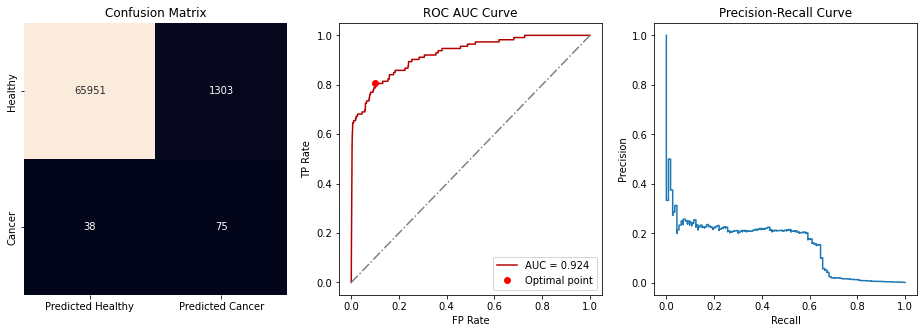

Threshold: 0.23434321582317352
     precision    recall  f1-score  support
0.0   0.999620  0.898489  0.946360  67254.0
1.0   0.013011  0.796460  0.025605    113.0
ROC AUC score: 0.9237922092208353
Accuracy Score: 0.8983181676488489
0.23434322


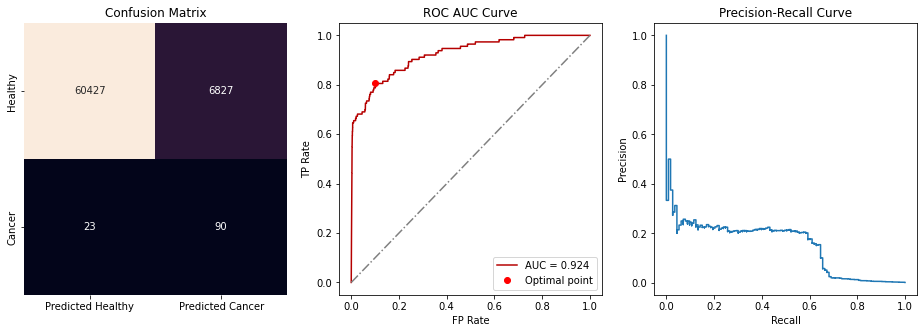

0.23434322
Filtered on: ('was_screened', [0])
     precision  recall  f1-score  support
0.0   0.000000     0.0  0.000000    242.0
1.0   0.196013     1.0  0.327778     59.0
ROC AUC score: 0.5434234486622777
Accuracy Score: 0.19601328903654486
0.9890137


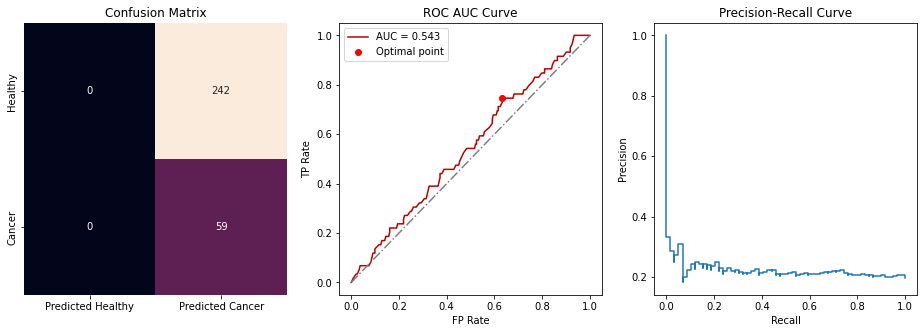

Filtered on: ('was_screened', [1])
     precision    recall  f1-score  support
0.0   0.999424  0.984167  0.991737  67012.0
1.0   0.014856  0.296296  0.028294     54.0
ROC AUC score: 0.8452937395402923
Accuracy Score: 0.9836131571884412
0.09613822


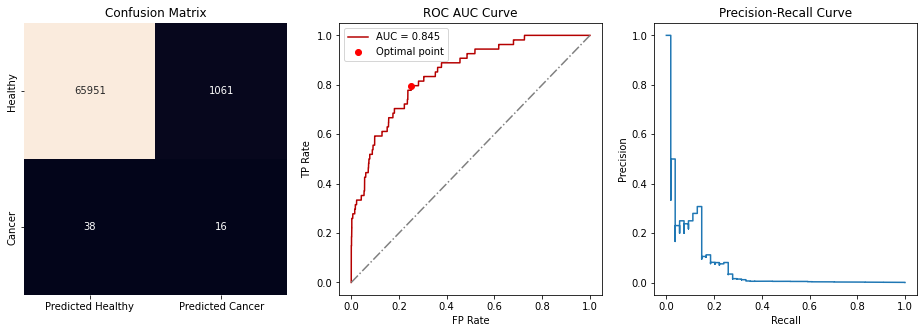

Filtered on: ('ovar_histtype', [2])
     precision    recall  f1-score  support
0.0   0.897143  0.501597  0.643443    313.0
1.0   0.227723  0.718750  0.345865     64.0
ROC AUC score: 0.6407498003194889
Accuracy Score: 0.5384615384615384
0.14328013


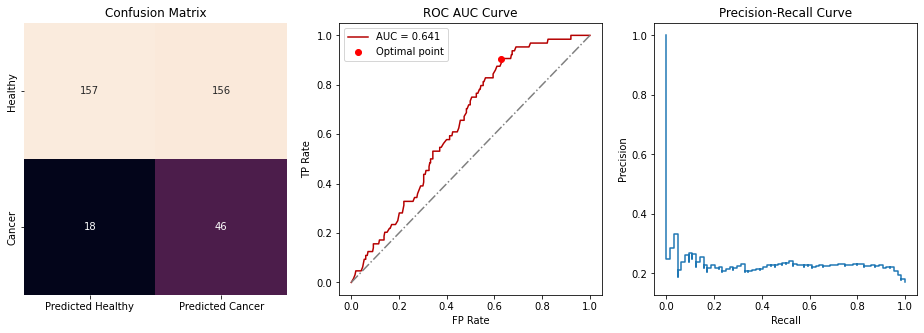

Filtered on: ('ovar_histtype', [2, 4, 6, 8, 9, 31])
     precision    recall  f1-score  support
0.0   0.889610  0.524904  0.660241    522.0
1.0   0.222571  0.676190  0.334906    105.0
ROC AUC score: 0.6410144134282065
Accuracy Score: 0.5502392344497608
0.23434322


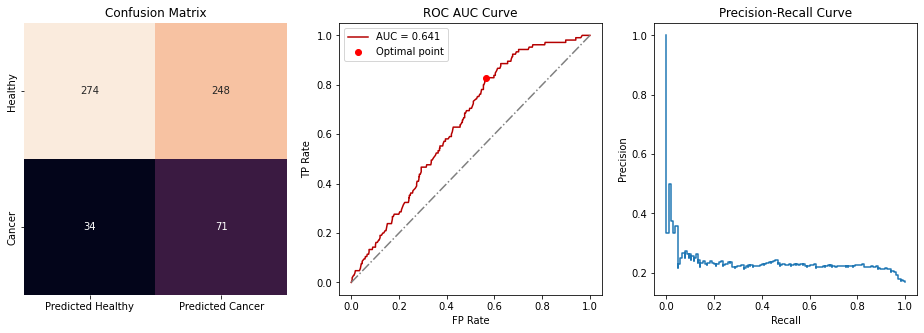

In [25]:
classifiers = {
    # 'LogisticRegression': LogisticRegression(C= 0.25, random_state= 0),
    # 'GaussianNB': GaussianNB(var_smoothing= 1e-09),
    # 'DecisionTreeClassifier': DecisionTreeClassifier(criterion= 'entropy'),
    # 'RandomForestClassifier': RandomForestClassifier(criterion= 'entropy', n_estimators= 200),
    'XGBClassifier': XGBClassifier(eval_metric= 'error', learning_rate= 0.1)
}
years = [1]
drop_n_features = 1
cv=False
for year in years:
    label = f'cancer_in_next_{year}_years' # 'cancer_in_next_10_years', 'ovar_cancer'
    df_top_feature_importances, df_feature_importance_tree, X_test_mismatch = run_classifiers(classifiers, processed_data_filtered, label, strategy='mean', cv=cv, drop_n_features = drop_n_features, num_folds=5, plot_tree=False, differentiate_confusion_matrix_over=differentiate_confusion_matrix_over)


`TODO:` divide them as FP and FN?

`TODO:` only keep columns with more than 1 unique value? 

In [15]:
len(X_test_mismatch)

42

In [16]:
false_negatives = pd.concat(np.array(X_test_mismatch)[:, 0])
false_negatives = false_negatives[false_negatives['cancer_in_next_1_years_prob'] < 0.14151879]
print_df(false_negatives)

+-------+-------+------------+-------------+-------+---------+----------+------------+-----------+-----------+-----------------+----------+-----------+----------+-----------+------------+------------+----------+-------------+-----------------+-----------------+--------------+------------+----------------+-----------------+----------+------------+------------+-------------+---------+-----------+---------------------+-----------+---------+---------+----------+----------+--------------+--------------+--------+---------+----------+------------+-----------------+-----------+-------------+--------------+-----------+--------------+------------+------------+--------------+----------+-------------+--------------+------------+-----------+--------+----------+-----------------------+-------------+-------------+---------+---------------------+-----------+-----------+-----------+-----------+-----------+----------+----------+-----------------+-----------+---------+-----------+---------------------+--

In [17]:
len(false_negatives)

21

In [18]:
print_df(pd.concat(X_test_mismatch[1][:2]))

+--------+-------+------------+-------------+-------+---------+-------+------------+-----------+-----------+-----------------+----------+-----------+----------+-----------+------------+------------+----------+-------------+-----------------+-----------------+--------------+------------+----------------+-----------------+----------+------------+------------+-------------+---------+-----------+---------------------+-----------+---------+---------+----------+----------+--------------+--------------+--------+---------+----------+------------+-----------------+-----------+-------------+--------------+-----------+--------------+------------+------------+--------------+----------+-------------+--------------+------------+-----------+--------+----------+-----------------------+-------------+-------------+---------+---------------------+-----------+-----------+-----------+-----------+-----------+----------+----------+-----------------+-----------+---------+-----------+---------------------+----

In [19]:
# drop col if the feature value of patient that was misclassified does not appear in the list of feature values of patients that were classified
df = pd.concat(X_test_mismatch[1][:2])
for col in df.columns:
    if df[col].iloc[0] in df[col].iloc[list(range(1, 6))].to_list():
        df.drop(col,inplace=True,axis=1)
print_df(df)
summary = summarize_features(df)

+--------+-------------+----------+----------+------------+------------+-------------+------------+-----------+----------+---------+----------+--------------+---------------+---------------+-------------+--------------+--------------+---------------+--------------+-------------+-----------+----------+-----------+---------+--------------+--------------+------------+--------------------------+-------------------------------+-------------------------------+------------+
|        |   arthrit_f |   bmi_20 |   bmi_50 |   bmi_curr |   cig_stop |   cig_years |   height_f |   llong_p |   lvol_p |   maxdi |   miscar |   ovary_diam |   ovary_diaml |   ovary_diamr |   ovary_vol |   ovary_voll |   ovary_volr |   ovcyst_diam |   pack_years |   rantero_p |   rlong_p |   rvol_p |   sisters |   volum |   weight20_f |   weight50_f |   weight_f |   cancer_in_next_1_years |   cancer_in_next_1_years_pred |   cancer_in_next_1_years_prob |   distance |
|--------+-------------+----------+----------+----------

In [20]:

print_df(summary)

+-----------------------------+----------------+---------+------------+-----------+----------+-----------+-----------+-----------+------------+
|                             |   unique count |   count |       mean |       std |      min |       25% |       50% |       75% |        max |
|-----------------------------+----------------+---------+------------+-----------+----------+-----------+-----------+-----------+------------|
| arthrit_f                   |              2 |       6 |   0.166667 |  0.408248 |   0      |   0       |   0       |   0       |   1        |
| bmi_20                      |              5 |       6 |  20.5633   |  0.942776 |  18.88   |  20.435   |  20.61    |  21.2425  |  21.45     |
| bmi_50                      |              6 |       6 |  22.8283   |  2.94331  |  18.88   |  20.7775  |  23.07    |  25.4075  |  25.75     |
| bmi_curr                    |              6 |       6 |  24.1817   |  3.27726  |  19.73   |  21.7325  |  24.82    |  26.9925  |  27.3

In [21]:

df = pd.concat(X_test_mismatch[4][:2])
for col in df.columns:
    if len(df[col].unique()) <= 2:
        df.drop(col,inplace=True,axis=1)
print_df(df)
summary = summarize_features(df)
print_df(summary)

+--------+-------+------------+-----------+----------+----------+------------+----------+------------+-----------------+----------+----------+-----------+-----------+------------+-------------+---------+-----------+-----------+-----------+----------+----------+--------------+---------------+---------------+-------------+--------------+--------------+---------------+--------------+--------------+---------+---------+-------------+-----------+-----------+----------+-----------+---------+--------------+--------------+------------+------------+
|        |   age |   agelevel |   bcontrt |   bmi_20 |   bmi_50 |   bmi_curr |   bq_age |   brothers |   ca125ii_level |   center |   educat |   fchilda |   fmenstr |   height_f |   lantero_p |   livec |   llong_p |   lmenstr |   ltran_p |   lvol_p |   miscar |   ovary_diam |   ovary_diaml |   ovary_diamr |   ovary_vol |   ovary_voll |   ovary_volr |   ovcyst_diam |   ph_any_muq |   ph_any_sqx |   prega |   pregc |   rantero_p |   rlong_p |   rtran_p

`TODO:` make spreadsheet with model performance for 1,3,5,10 years. Print out trees, top 5 features. Send models

In [22]:
ranked_df = df_feature_importance_tree.rank(method='max')
ranked_df['feature'] = df_feature_importance_tree['feature']
ranked_df = ranked_df.drop('feature', axis=1)
ranked_df = ranked_df.T
ranked_df.columns = df_feature_importance_tree['feature']
ranked_df = ranked_df.astype('float')
description_rank = ranked_df.describe().T
description_rank.to_csv(f'./feature_importance_rank_{drop_n_features}_trials.csv')

KeyError: 'feature'

In [ ]:

# Prints the table of missing values with columns for df filtered for each of the values of on_col
def df_missing_val_distribution_over_col(df, on_col, cutoff_percentage, title, show_missing=True):
    iterate_over_on_col = sorted(df[on_col].unique())
    suffixes=[]
    # since get_cols_missing_percentage will produce columns with the same names, we want to create suffixes to differentiate over on_col values
    for on_col_val in iterate_over_on_col:
        suffixes.append(f'_{on_col}_{on_col_val}')
    # We are going to merge all of the 
    df_missing = None
    for on_col_val in iterate_over_on_col:

        df_on_col = df[df[on_col] == on_col_val]

        df_missing_on_col = get_cols_missing_percentage(cutoff_percentage, df_on_col, f'{title} with {on_col}_{on_col_val}', show_missing=show_missing)
        
        if df_missing is not None:
            df_missing = df_missing.merge(df_missing_on_col, on='column_name', how='inner', suffixes=suffixes)
        else:
            df_missing = df_missing_on_col
    print_df(df_missing)


def df_filter_val_distribution(sourse_df, on_col, make_unique_over_cols, name, hist=True, cutoff_percentage=0):
    unique_vals_list = [sorted(sourse_df[make_unique_over_col].unique()) for make_unique_over_col in make_unique_over_cols]
    unique_combinations_col_vals = get_unique_combinations(unique_vals_list)
    num_records, num_unique = print_records_vs_unique(sourse_df, 'plco_id', name)
    unique_combinations_col_vals = sorted(unique_combinations_col_vals)
    unique_records = [{} for _ in range(len(unique_combinations_col_vals)+1)]
    unique_records[0] = {
            'filtered_on': f'{name} total'
        }
    
    iterate_over_on_col = sorted(sourse_df[on_col].unique())
    for on_col_val in iterate_over_on_col:
        num_records, num_unique = print_records_vs_unique(sourse_df[sourse_df[on_col] == on_col_val], 'plco_id', f'{name} with {on_col}_{on_col_val}')
        unique_records[0][f'num_records_{on_col}:{on_col_val}'] = num_records
        unique_records[0][f'num_unique_id_{on_col}:{on_col_val}'] = num_unique
    print()
    print()
    for j in range(len(unique_combinations_col_vals)):
        unique_combination = unique_combinations_col_vals[j]
        filter = True
        filtered_on = ''
        for i in range(len(make_unique_over_cols)):
            variable_col = make_unique_over_cols[i]
            val = unique_combination[i]
            filter = filter & (sourse_df[variable_col] == val)
            filtered_on += f'{variable_col}: {val} '
        df = sourse_df[filter]
        if len(make_unique_over_cols) > 0:
            df = df.drop(make_unique_over_cols, axis=1)

        title = f'{name} filtered on {filtered_on}'
        print(title)

        df_missing = None
        unique_records[j+1]['filtered_on'] = title
        for on_col_val in iterate_over_on_col:
            df_on_col = df[df[on_col] == on_col_val]
            num_records, num_unique = print_records_vs_unique(df_on_col, 'plco_id', f'{title} with {on_col}_{on_col_val}')
            df_missing_on_col = get_cols_missing_percentage(cutoff_percentage, df_on_col, f'{title} with {on_col}_{on_col_val}')
            unique_records[j+1][f'num_records_{on_col}:{on_col_val}'] = num_records
            unique_records[j+1][f'num_unique_id_{on_col}:{on_col_val}'] = num_unique
            if hist:
                fig, ax = plt.subplots(1, 1, figsize=(20,15))
                df.hist(ax=ax, bins=30)
                plt.show()
        df_missing_val_distribution_over_col(df, on_col, cutoff_percentage, title, show_missing=False)
        df = impute_with_val(df, df.columns, -1)
        print('\n\n')
    print_df(pd.DataFrame(unique_records).sort_values('filtered_on'))

def df_filter_val_distribution_on_cancer(source_df, make_unique_over_cols, name, hist=False, cutoff_percentage=0):
    df_cancer = source_df[source_df['plco_id'].isin(personal_data_cancer['plco_id'])]
    df_cancer['cancer'] = 1
    df_no_cancer = source_df[source_df['plco_id'].isin(personal_data_no_cancer['plco_id'])]
    df_no_cancer['cancer'] = 0
    df = pd.concat([df_cancer, df_no_cancer], axis=0)
    df_filter_val_distribution(df, 'cancer', make_unique_over_cols, name, hist=hist, cutoff_percentage=cutoff_percentage)
make_unique_over_cols = ['dummy']
df = merged_df
df['dummy'] = 0
df_filter_val_distribution_on_cancer(df, make_unique_over_cols, 'Personal Data', hist=False, cutoff_percentage=0)

Num of records in Personal Data dataset: 336206
Num of unique plco_id in Personal Data dataset: 31165
Num of records in Personal Data with cancer_0 dataset: 332709
Num of unique plco_id in Personal Data with cancer_0 dataset: 30552
Num of records in Personal Data with cancer_1 dataset: 3497
Num of unique plco_id in Personal Data with cancer_1 dataset: 613


Personal Data filtered on dummy: 0 
Num of records in Personal Data filtered on dummy: 0  with cancer_0 dataset: 332709
Num of unique plco_id in Personal Data filtered on dummy: 0  with cancer_0 dataset: 30552
174 columns were over 0 missing. This is the list of columns: ['ovar_cancer', 'cancer_in_next_1_years', 'study_yr', 'ovar_cancer_years', 'in_TGWAS_population', 'dual', 'agelevel', 'age', 'center', 'ph_ovar_trial', 'ph_any_trial', 'was_screened', 'race7', 'cancer', 'plco_id', 'ovary_trial_flag', 'ph_any_bq', 'menstrs_stat_type', 'bq_age', 'ph_ovar_bq', 'post_menopausal', 'smoked_f', 'cig_stat', 'ovariesr_f', 'preg_f', 'pelvic_h

In [ ]:
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    # GaussianNB(),
    # XGBClassifier(),
    # LogisticRegression(max_iter=200)
]
# Calculate years before cancer
def f_score(X_train, X_test, y_train, y_test, classifiers):
    for clf in classifiers:
        s = time.time()
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        f = f1_score(y_true=y_test,y_pred=y_pred,average="macro")
        e = time.time()
        print(f"Score: {round(f,3)} \t Time(in secs): {round(e-s,3)} \t Classifier: {clf.__class__.__name__}")
# f_score(X_train, X_test, y_train, y_test, classifiers)

In [ ]:
def select_using_model(x,y):
    sel = SelectFromModel(XGBClassifier())
    sel.fit(x,y)

In [ ]:
def select_using_score_func(X_train, y_train):
    # configure to select all features
    fs = SelectKBest(score_func=f_classif, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # what are scores for the features
    features_scores = pd.DataFrame(x.columns)
    features_scores['scores'] = fs.scores_
    features_scores = features_scores.sort_values('scores', ascending=False)
    features_scores.to_csv('./feature_selection/all_features_new_cols__mean_imputed.csv')

In [ ]:
# Determine on which features to use mean imputation and on which ones to replace with -1

 The initial dataset had 181 variables (Appendix 1). Variables were ranked by their F-score, which is the harmonic mean of precision and recall, with those with an F-score closest to 1.0 demonstrating high correlation with treatment success [10]. Experts in the treatment of BPH also selected variables for inclusion into the models irrespective of the F-Score, these variables, plus those with a high F-Score were selected for inclusion in initial model development.. The actual variables used by our models were a subset of these, and the number in any given fold and subgroup was dynamically determined by treating this as a hyper-parameter and tuning it as described below.